In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
NUM_LANGS = 5

ENGLISH = 0
SPANISH = 1
FRENCH = 2
ITALIAN = 3
GERMAN = 4

def get_i_to_l():
    return {0: "EN", 1: "SP", 2: "FR", 3: "IT", 4: "GE"}
itol = get_i_to_l()

In [3]:
def get_sent(path):
    sentences = []
    with open(path, "r") as f:
        sentences.extend(f.readlines())
    return sentences

spanish = get_sent("langid/sentences.es.txt")
french = get_sent("langid/sentences.fr.txt")
english = get_sent("langid/sentences.en.txt")
italian = get_sent("langid/sentences.it.txt")
german = get_sent("langid/sentences.de.txt")
def label(sentences, label):
    return list(zip(sentences, [label] * len(sentences)))
spanish_labeled = label(spanish, SPANISH)
french_labeled = label(french, FRENCH)
english_labeled = label(english, ENGLISH)
italian_labeled = label(italian, ITALIAN)
german_labeled = label(german, GERMAN)
labeled = spanish_labeled + french_labeled + english_labeled + italian_labeled + german_labeled
random.shuffle(labeled)

In [4]:
def get_stoi(sentences):
  stoi = {}
  chars = set()
  for sent in sentences:
    for c in sent:
      chars.add(c)
  chars = sorted(list(chars))
  for i, c in enumerate(chars):
    stoi[c] = i
  return stoi

stoi = get_stoi(spanish + french + english + italian + german)


In [5]:

SAMPLE_LENGTH = 64
def get_X_and_Y(stoi, labeled):
  prefixes = []
  for sentence, _ in labeled:
      prefix = sentence[:SAMPLE_LENGTH]
      prefix += " " * (SAMPLE_LENGTH - len(prefix))
      prefixes.append(prefix)
  xs = []
  for prefix in prefixes:
      x = []
      for c in prefix:
          x.append(stoi[c])
      xs.append(x)
  x = torch.tensor(xs)
  y = torch.tensor([label for _, label in labeled])
  return x, y

In [6]:
HIDDEN_LENGTH = 100
EMBED_SIZE = 16
class Model(torch.nn.Module):
    def __init__(self, stoi):
        super().__init__()
        self.embedding = torch.nn.Embedding(len(stoi), EMBED_SIZE)
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(EMBED_SIZE * SAMPLE_LENGTH, HIDDEN_LENGTH), torch.nn.ReLU(),
            torch.nn.Linear(HIDDEN_LENGTH, HIDDEN_LENGTH), torch.nn.ReLU(),
            torch.nn.Linear(HIDDEN_LENGTH, NUM_LANGS)
        )
    def forward(self, x):
        emb = self.embedding(x).view(x.shape[0], -1)
        return self.layers(emb)

In [7]:
model = Model(stoi)

X, Y = get_X_and_Y(stoi, labeled)

Xtrain = X[:int(X.shape[0] * .9)]
Xtest = X[int(X.shape[0] * .9):]
Ytrain = Y[:int(Y.shape[0] * .9)]
Ytest = Y[int(Y.shape[0] * .9):]

for p in model.parameters():
    p.requires_grad = True

with torch.no_grad():
    model.layers[-1].weight *= .1
i = 0
losses = []
val_loss = []

In [8]:
learning_rate = .1
for _ in range(1000):
    Yhat = model(Xtrain)
    regs = []
    for parameter in model.parameters():
        regs.append(parameter.abs().sum())
    reg = torch.stack(regs).sum()
    ce = F.cross_entropy(Yhat, Ytrain)
    loss = ce + .001 * reg
    with torch.no_grad():
        Yhattest = model(Xtest)
        losstest = F.cross_entropy(Yhattest, Ytest)
        val_loss.append(losstest.item())

    for p in model.parameters():
        p.grad = None
    loss.backward()
    for p in model.parameters():
        p.data += -learning_rate * p.grad
    losses.append(ce.item())


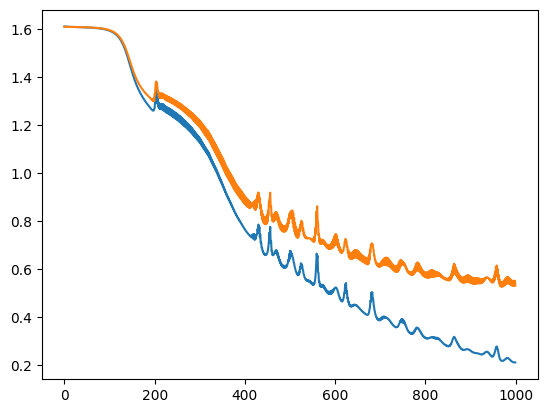

In [9]:
plt.plot(losses)
plt.plot(val_loss)
plt.show()

In [10]:
print(loss.item())
Yhat = model(Xtest)
loss = F.cross_entropy(Yhat, Ytest)
print(loss.item())

(Yhat.argmax(dim=1) == Ytest).float().sum()

2.1885228157043457
0.5543806552886963


tensor(789.)

In [11]:
X, _ = get_X_and_Y(stoi, [("Wikipédia est un projet d’encyclopédie collective en ligne, universelle, multilingue et fonctionnant sur le principe du wiki. Ce projet vise à offrir un contenu librement réutilisable, objectif et vérifiable, que chacun peut modifier et améliorer.", ENGLISH)])
itol[model(X).softmax(1).argmax().item()]

'EN'